#### Generate train and text data

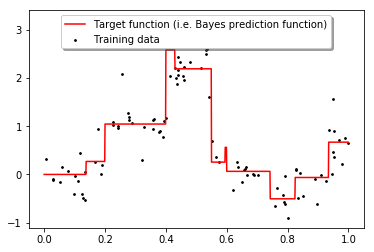

In [1]:
from sklearn.model_selection import train_test_split
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle


def step_fn_generator(stepLoc=0):
    def f(x):
        ret = np.zeros(len(x))
        ret[x >= stepLoc] = 1
        return ret
    return f

def linear_comb_generator(fns, coefs):
    def f(x):
        return sum(fns[i](x) * coefs[i] for i in range(len(fns)))
    return f

def get_target_and_featurizer(num_basis_fns = 100, num_nonzero = 10, coefs_true=None):
    # We'll create a basis of step functions on the interval [0,1]. We'll then
    # construct a linear combination of these step functions to be our target
    # function. We'll construct a function to "featurize" an input in [0,1]
    # into the evaluations of all functions in the basis on the input.
    # Optionally: If coefs_true is provided, they will be used to generate
    # target_fn and featurize.
    # Construct basis, to be used for generating target function

    if coefs_true is not None:
        num_basis_fns = len(coefs_true)
    else:
        nonzero_indices = np.random.choice(num_basis_fns, num_nonzero)
        coefs_true = np.zeros(num_basis_fns)
        coefs_true[nonzero_indices] = np.random.randn(num_nonzero)

    all_basis_fns = [step_fn_generator(stepLoc=s)
                     for s in np.linspace(0, 1, num_basis_fns, endpoint=False)]

    # Construct target function (the Bayes prediction function)
    target_fn = linear_comb_generator(all_basis_fns, coefs_true)

    def featurize(x):
        n = len(x)
        # Featurize input values in [0,1]
        X_ftrs = np.empty((n, num_basis_fns))
        for ftr_num in range(num_basis_fns):
            X_ftrs[:, ftr_num] = all_basis_fns[ftr_num](x)
        return X_ftrs

    return target_fn, coefs_true, featurize

def generate_data(target_fn, n=1000, noise_scale=.25, tdof=6):
    # Construct dataset
    x = np.sort(np.random.rand(n)) #chooses uniformly from [0,1)
    y_target = target_fn(x)
    y = y_target + noise_scale * np.random.standard_t(tdof,n)
    return x, y

def get_data_splits(x, y, test_frac=.2):
    ## Based on https://github.com/ageron/handson-ml/blob/master/02_end_to_end_machine_learning_project.ipynb
    n = len(y)
    shuffled_indices = np.random.permutation(n)
    n_test = int(n * test_frac)
    n_train = n - n_test
    indices_test = shuffled_indices[:n_test]
    indices_train = shuffled_indices[n_test:]
    y_train = y[indices_train]
    x_train = x[indices_train]
    y_test = y[indices_test]
    x_test = x[indices_test]
    return x_train, y_train, x_test, y_test

def generate_problem(n=200, num_basis_fns=400, num_nonzero=10, noise_scale=.25, tdof=6, test_frac=.2, write_problem=False, file_name="lasso_data.pickle"):
    target_fn, coefs_true, featurize = get_target_and_featurizer(num_basis_fns, num_nonzero)
    x, y = generate_data(target_fn, n, noise_scale, tdof)
    x_train, y_train, x_test, y_test = get_data_splits(x, y, test_frac)

    if write_problem:
        print ("Saving problem to disk.")
        data = {"coefs_true":coefs_true, "x_train":x_train,
                "y_train":np.copy(y_train), "x_test":x_test, "y_test":y_test}
        with open(file_name, 'wb') as outfile:
            pickle.dump(data, outfile, protocol=2)

    return x_train, y_train, x_test, y_test, target_fn, coefs_true, featurize

def reconstitute_problem(coefs_true, x_train, y_train, x_test, y_test):
    target_fn, coefs_true, featurize = get_target_and_featurizer(coefs_true=coefs_true)
    return x_train, y_train, x_test, y_test, target_fn, coefs_true, featurize

def load_problem(file_name):
    file_name = "lasso_data.pickle"
    f_myfile = open(file_name, 'rb')
    data = pickle.load(f_myfile)
    f_myfile.close()
    return reconstitute_problem(data["coefs_true"], data["x_train"], data["y_train"],
                                data["x_test"], data["y_test"])


lasso_data_fname = "lasso_data.pickle"
LOAD_PROBLEM=True
GENERATE_PROBLEM=False
WRITE_PROBLEM=False
if GENERATE_PROBLEM:
    n=1000
    test_frac=.9
    num_basis_fns=400
    num_nonzero=10
    noise_scale=.25 # scale factor on noise
    tdof = 6 # degrees of freedom of t-distribution generating noise
    x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = generate_problem(n=n, num_basis_fns=num_basis_fns, num_nonzero=num_nonzero, noise_scale=noise_scale, test_frac=test_frac, write_problem=WRITE_PROBLEM, file_name=lasso_data_fname)

if LOAD_PROBLEM:
    x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(lasso_data_fname)

# Let's plot the target function (i.e. the Bayes prediction function) as
# well as the noisy observations from the training data, as a function of
# the original input space, which is the interval [0,1).
fig, ax = plt.subplots()
plt.scatter(x_train, y_train, s=3, color='k', label='Training data')
x = np.arange(0,1,.001)
ax.plot(x, target_fn(x), 'r', label='Target function (i.e. Bayes prediction function)')
legend = ax.legend(loc='upper center', shadow=True)
plt.show(block=False)


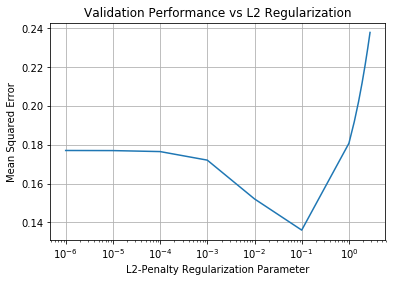

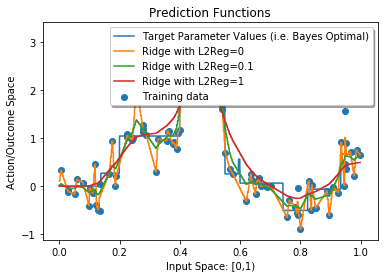

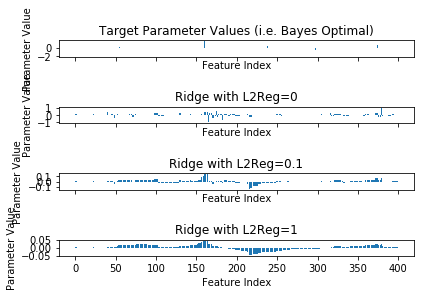

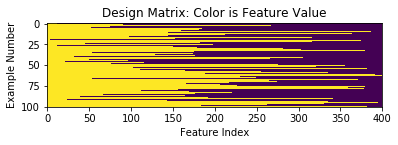

Hoping this is very close to 0:3.605403901880153e-10
    param_l2reg  mean_test_score  mean_train_score
0      0.000001         0.176994          0.011543
1      0.000010         0.176943          0.011543
2      0.000100         0.176436          0.011555
3      0.001000         0.172033          0.012392
4      0.010000         0.152089          0.028988
5      0.100000         0.136039          0.086856
6      1.000000         0.180699          0.197889
7      1.300000         0.191831          0.217117
8      1.600000         0.202102          0.234209
9      1.900000         0.211730          0.249809
10     2.200000         0.220830          0.264270
11     2.500000         0.229473          0.277808
12     2.800000         0.237711          0.290568


C:\Applications\Programming\Anaconda\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [10]:
"""
Ridge regression using scipy's minimize function and demonstrating the use of
sklearn's framework.

Author: David S. Rosenberg <david.davidr@gmail.com>
License: Creative Commons Attribution 4.0 International License
"""
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd

from setup_problem import load_problem

class RidgeRegression(BaseEstimator, RegressorMixin):
    """ ridge regression"""

    def __init__(self, l2reg=1):
        if l2reg < 0:
            raise ValueError('Regularization penalty should be at least 0.')
        self.l2reg = l2reg

    def fit(self, X, y=None):
        n, num_ftrs = X.shape
        # convert y to 1-dim array, in case we're given a column vector
        y = y.reshape(-1)
        def ridge_obj(w):
            predictions = np.dot(X,w)
            residual = y - predictions
            empirical_risk = np.sum(residual**2) / n
            l2_norm_squared = np.sum(w**2)
            objective = empirical_risk + self.l2reg * l2_norm_squared
            return objective
        self.ridge_obj_ = ridge_obj

        w_0 = np.zeros(num_ftrs)
        self.w_ = minimize(ridge_obj, w_0).x
        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        return np.dot(X, self.w_)

    def score(self, X, y):
        # Average square error
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        residuals = self.predict(X) - y
        return np.dot(residuals, residuals)/len(y)



def compare_our_ridge_with_sklearn(X_train, y_train, l2_reg=1):
    # First run sklearn ridge regression and extract the coefficients
    from sklearn.linear_model import Ridge
    # Fit with sklearn -- need to multiply l2_reg by sample size, since their
    # objective function has the total square loss, rather than average square
    # loss.
    n = X_train.shape[0]
    sklearn_ridge = Ridge(alpha=n*l2_reg, fit_intercept=False, normalize=False)
    sklearn_ridge.fit(X_train, y_train)
    sklearn_ridge_coefs = sklearn_ridge.coef_

    # Now run our ridge regression and compare the coefficients to sklearn's
    ridge_regression_estimator = RidgeRegression(l2reg=l2_reg)
    ridge_regression_estimator.fit(X_train, y_train)
    our_coefs = ridge_regression_estimator.w_

    print("Hoping this is very close to 0:{}".format(np.sum((our_coefs - sklearn_ridge_coefs)**2)))

def do_grid_search_ridge(X_train, y_train, X_val, y_val):
    # Now let's use sklearn to help us do hyperparameter tuning
    # GridSearchCv.fit by default splits the data into training and
    # validation itself; we want to use our own splits, so we need to stack our
    # training and validation sets together, and supply an index
    # (validation_fold) to specify which entries are train and which are
    # validation.
    X_train_val = np.vstack((X_train, X_val))
    y_train_val = np.concatenate((y_train, y_val))
    val_fold = [-1]*len(X_train) + [0]*len(X_val) #0 corresponds to validation

    # Now we set up and do the grid search over l2reg. The np.concatenate
    # command illustrates my search for the best hyperparameter. In each line,
    # I'm zooming in to a particular hyperparameter range that showed promise
    # in the previous grid. This approach works reasonably well when
    # performance is convex as a function of the hyperparameter, which it seems
    # to be here.
    param_grid = [{'l2reg':np.unique(np.concatenate((10.**np.arange(-6,1,1),
                                           np.arange(1,3,.3)
                                             ))) }]

    ridge_regression_estimator = RidgeRegression()
    grid = GridSearchCV(ridge_regression_estimator,
                        param_grid,
                        return_train_score=True,
                        cv = PredefinedSplit(test_fold=val_fold),
                        refit = True,
                        scoring = make_scorer(mean_squared_error,
                                              greater_is_better = False))
    grid.fit(X_train_val, y_train_val)

    df = pd.DataFrame(grid.cv_results_)
    # Flip sign of score back, because GridSearchCV likes to maximize,
    # so it flips the sign of the score if "greater_is_better=FALSE"
    df['mean_test_score'] = -df['mean_test_score']
    df['mean_train_score'] = -df['mean_train_score']
    cols_to_keep = ["param_l2reg", "mean_test_score","mean_train_score"]
    df_toshow = df[cols_to_keep].fillna('-')
    df_toshow = df_toshow.sort_values(by=["param_l2reg"])
    return grid, df_toshow

def compare_parameter_vectors(pred_fns):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "coefs" key
    fig, axs = plt.subplots(len(pred_fns),1, sharex=True)
    num_ftrs = len(pred_fns[0]["coefs"])
    for i in range(len(pred_fns)):
        title = pred_fns[i]["name"]
        coef_vals = pred_fns[i]["coefs"]
        axs[i].bar(range(num_ftrs), coef_vals)
        axs[i].set_xlabel('Feature Index')
        axs[i].set_ylabel('Parameter Value')
        axs[i].set_title(title)
        #axs[i].set_ylim([-2,2])

    fig.subplots_adjust(hspace=0.3)
    plt.tight_layout()
    return fig

def plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best"):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "preds" key. The value corresponding to the "preds" key is an array of
    # predictions corresponding to the input vector x. x_train and y_train are
    # the input and output values for the training data
    fig, ax = plt.subplots()
    ax.set_xlabel('Input Space: [0,1)')
    ax.set_ylabel('Action/Outcome Space')
    ax.set_title("Prediction Functions")
    plt.scatter(x_train, y_train, label='Training data')
    for i in range(len(pred_fns)):
        ax.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"])
    legend = ax.legend(loc=legend_loc, shadow=True)
    return fig

def main():
    lasso_data_fname = "lasso_data.pickle"
    x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(lasso_data_fname)

    # Generate features
    X_train = featurize(x_train)
    X_val = featurize(x_val)

    #Visualize training data
    fig, ax = plt.subplots()
    ax.imshow(X_train)
    ax.set_title("Design Matrix: Color is Feature Value")
    ax.set_xlabel("Feature Index")
    ax.set_ylabel("Example Number")
    plt.show(block=False)

    # Compare our RidgeRegression to sklearn's.
    compare_our_ridge_with_sklearn(X_train, y_train, l2_reg = 1.5)

    # Do hyperparameter tuning with our ridge regression
    grid, results = do_grid_search_ridge(X_train, y_train, X_val, y_val)
    print(results)

    # Plot validation performance vs regularization parameter
    fig, ax = plt.subplots()
    ax.loglog(results["param_l2reg"], results["mean_test_score"])
    ax.semilogx(results["param_l2reg"], results["mean_test_score"])
    ax.grid()
    ax.set_title("Validation Performance vs L2 Regularization")
    ax.set_xlabel("L2-Penalty Regularization Parameter")
    ax.set_ylabel("Mean Squared Error")
    fig.show()

    # Let's plot prediction functions and compare coefficients for several fits
    # and the target function.
    pred_fns = []
    x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
    name = "Target Parameter Values (i.e. Bayes Optimal)"
    pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })

    l2regs = [0, grid.best_params_['l2reg'], 1]
    X = featurize(x)
    for l2reg in l2regs:
        ridge_regression_estimator = RidgeRegression(l2reg=l2reg)
        ridge_regression_estimator.fit(X_train, y_train)
        name = "Ridge with L2Reg="+str(l2reg)
        pred_fns.append({"name":name,
                         "coefs":ridge_regression_estimator.w_,
                         "preds": ridge_regression_estimator.predict(X) })

    f = plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")
    f.show()

    f = compare_parameter_vectors(pred_fns)
    f.show()

if __name__ == '__main__':
    main()


In [3]:
#Confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
x_train_f=featurize(x_train)
x_val_f=featurize(x_val)

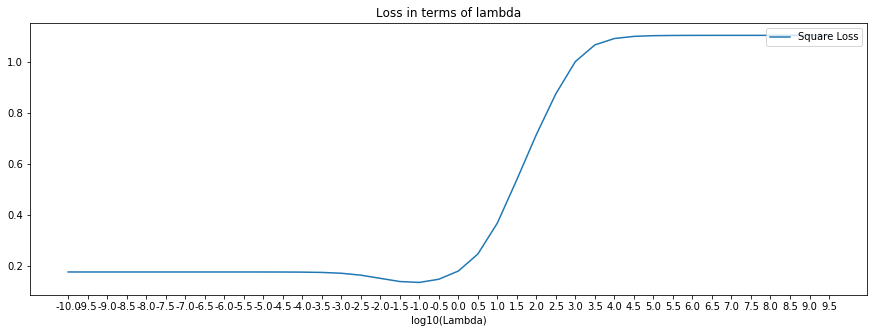

In [4]:
%matplotlib inline
def func2_1():
    lam=([10**i for i in np.arange(-10.0,10.0,0.5)])
    loss=np.zeros(len(lam))

    for i,lambda_i in enumerate(lam):
        ridge_regression_estimator = RidgeRegression(l2reg=lambda_i)
        ridge_regression_estimator.fit(x_train_f, y_train)
        our_coefs = ridge_regression_estimator.w_
        loss[i]=ridge_regression_estimator.score(x_val_f,y_val)

    #print(loss)
    
    lines=locals()
    fig,ax1=plt.subplots(figsize=(15,5))
    lines['lambda'],=ax1.plot(np.log10(lam),loss)
    ax1.legend((['Square Loss']),loc='upper right')
    ax1.set_title('Loss in terms of lambda')
    ax1.set_xlabel('log10(Lambda)')
    plt.xticks(np.log10(lam),np.log10(lam))
    #print(lam)
    plt.show()
    
if __name__=="__main__":
    func2_1()

#### 2.2

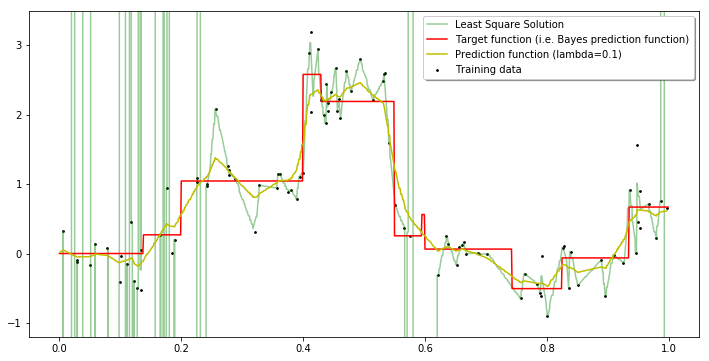

C:\Applications\Programming\Anaconda\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


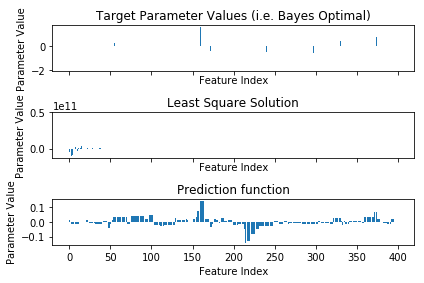

In [51]:
def func2_2():
    from sklearn.linear_model import LinearRegression
    
    #Data Visualization
    lines=locals() #Initialize lines
    fig1, ax1 = plt.subplots(figsize=(12,6))
    x = np.arange(0,1,.001)
    x_val_f=featurize(np.sort(x_val))
    #LR part
    LR = LinearRegression()
    LR.fit(x_train_f,y_train)
    y_pred_LR=LR.predict(x_val_f)
    #LR.coef_
    #RR part
    ridge_regression_estimator = RidgeRegression(l2reg=0.1)
    ridge_regression_estimator.fit(x_train_f, y_train)
    our_coefs = ridge_regression_estimator.w_
    y_pred=ridge_regression_estimator.predict(x_val_f)
    
    lines['TD']=plt.scatter(x_train, y_train, s=3, color='k', label='Training data')
    lines['LR'],=ax1.plot(np.sort(x_val), y_pred_LR, 'g', alpha=0.4, label='Least Square Solution')
    lines['TF'],=ax1.plot(x, target_fn(x), 'r', label='Target function (i.e. Bayes prediction function)')
    lines['PD'],=ax1.plot(np.sort(x_val),y_pred,'y',label='Prediction function (lambda=0.1)')
    legend = ax1.legend(loc='upper right', shadow=True)
    ax1.set_ylim([-1.2,3.5])
    plt.show(block=False)
    
    #Func Visualization
    #fig2, ax2 = plt.subplots(figsize=(12,6))
    pred_fns=[]
    x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
    X=featurize(x)
    name = "Target Parameter Values (i.e. Bayes Optimal)"
    pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })
    name="Least Square Solution"
    pred_fns.append({"name":name,
                     "coefs":LR.coef_,
                     "preds": LR.predict(X) })
    name="Prediction function"
    pred_fns.append({"name":name,
                     "coefs":ridge_regression_estimator.w_,
                     "preds": ridge_regression_estimator.predict(X) })

    f = compare_parameter_vectors(pred_fns)
    f.show()

if __name__=='__main__':
    func2_2()

<b>Patterns:</b><br>
The pattern of target function is quite simple, with only a few non-zero parameters and the scale is all around $O(10^{0})$. Since the Least Square method is more about construct a hyper-plane, which could not simulate the distribution of this dataset well, some parameters turn to be very huge in magnitude. The Ridge Regression method could predict the dataset pretty well, and with the figures, we could conclude that coefficients near feature index 150 and 220 have the most weight.

#### 2.3

In [100]:
def func2_3():
    from sklearn.metrics import confusion_matrix
    epsilon=np.array([i for i in np.arange(0.01,0.14,0.02)])
    ridge_regression_estimator = RidgeRegression(l2reg=0.1)
    ridge_regression_estimator.fit(x_train_f, y_train)
    our_coefs = np.abs(ridge_regression_estimator.w_)
    true_coefs_bool=np.array(np.abs(coefs_true)).astype(bool).astype(np.int32)
    class_names=(['0','1'])
    #plt.figure()
    for ep in epsilon:
        our_coefs_bool=np.array([j<ep for j in our_coefs]).astype(np.int32)
        cnf_matrix = confusion_matrix(true_coefs_bool, our_coefs_bool)
        print("cnf_matrix, epsilon="+str(ep))
        print(cnf_matrix)
        #plot_confusion_matrix(cnf_matrix, classes=class_names,
        #                      title='Confusion matrix, epsilon=i')
    return(ridge_regression_estimator.w_)
if __name__=="__main__":
    RR_w=func2_3()

cnf_matrix, epsilon=0.01
[[284 106]
 [ 10   0]]
cnf_matrix, epsilon=0.03
[[ 98 292]
 [  7   3]]
cnf_matrix, epsilon=0.05
[[ 24 366]
 [  3   7]]
cnf_matrix, epsilon=0.07
[[ 21 369]
 [  2   8]]
cnf_matrix, epsilon=0.09
[[ 12 378]
 [  2   8]]
cnf_matrix, epsilon=0.11
[[ 10 380]
 [  2   8]]
cnf_matrix, epsilon=0.13
[[ 10 380]
 [  2   8]]


<b>Conclusion:</b><br>
The precision of predicting the sparsity pattern of true parameters is really low, no matter what threshold we set. It's not a good idea to do that.

### 3. Coordinate Descent for Lasso

#### 3.1 Experiments with the Shooting Algorithm
#### 3.1.1 Rewrite cordinate descent with matrix and vector operations
Initialize $w=(X^{T}X+\lambda{I})^{-1}X^{T}y$ (or maybe the RR solution of w, or 0)<br>
<b>repeat:</b><br>
&emsp;for j=1,...,D do:<br>
&emsp;&emsp;$a_{j}=2||X_{j}||_{2}^{2}$<br>
&emsp;&emsp;$c_{j}=2(X_{j}^{T}y)-2||X_{j}^{T}(w^{T}X^{T})^{T}||_{2}^{2}+2w_{j}||X_{j}||_{2}^{2}$<br>
&emsp;&emsp;$w_{j}=sign(\frac{c_{j}}{a_{j}})(|\frac{c_{j}}{a_{j}}|-\frac{\lambda}{a_{j}})_{+}$<br>
<b>until</b> converged;

#### 3.1.2 Function for computing the Lasso

In [6]:
def func_3_1_2_Lasso(X,y,w_init=0,lambda_reg=0.1,init='default',epsilon=1e-8,n=1000,randomize=False):
    num_feat=X.shape[1]
    num_ins=X.shape[0]
    loss_hist=np.zeros(((n+1),num_feat))
    loss_temp=999
    a=np.zeros(num_feat)
    c=np.zeros(num_feat)
    if init=='default':
        #w=np.dot(np.linalg.inv(np.dot(X.T,X)+lambda_reg*np.eye(num_feat)),np.dot(X.T,y))
        w=np.zeros(num_feat)
    else:
        w=w_init
    #print(w)
    loss_hist[0]=np.sum((np.dot(w,X.T)-y)**2)+lambda_reg*np.sum(np.abs(w))
    break_sign=False
    for i in range(n):
        if break_sign==True:
            break
        list_feat=np.array([k for k in range(num_feat)])
        if randomize==True:
            random.shuffle(list_feat)
        for j in list_feat:
            a[j]=2*np.sum(X[:,j]**2)
            c[j]=2*np.sum(np.dot(X[:,j].T,y))-2*np.sum(np.dot(X[:,j].T,np.dot(w,X.T).T))
            +2*w[j]*np.sum(np.square(X[:,j]))
            if a[j]==0:
                w[j]=0
            else:
                ca=c[j]/a[j]
                la=lambda_reg/a[j]
                if (np.abs(ca)-la)>0:
                    cp=np.abs(ca)-la
                else:
                    cp=0
                w[j]=(ca/np.abs(ca))*cp
            loss_hist[i+1][j]=np.sum((np.dot(w,X.T)-y)**2)+lambda_reg*np.sum(np.abs(w))
            #print(a[j],c[j],w[j],loss_hist[i+1][j])
        if loss_temp-np.mean(loss_hist[i+1])<epsilon and loss_temp-np.mean(loss_hist[i+1])>0:
            break_sign=True
            loss_temp=np.mean(loss_hist[i+1])
            print(i)
            break
        loss_temp=np.mean(loss_hist[i+1])
    print(np.mean(loss_hist[i+1]))
    return(w,loss_temp,loss_hist)

#### 3.1.3 Lasso parameter selection and comparation

15.2405818919
15.3613392738
15.5204707628
15.8282543646
16.4089822649
17.4568540546
19.3659463934
23.0146178842
29.7737631513
41.7837556019
[ 142.33805693  142.27625136  142.26146724  142.24533002  142.22474267
  142.14912402  142.67903363  144.45303613  150.06732492  166.51386191]


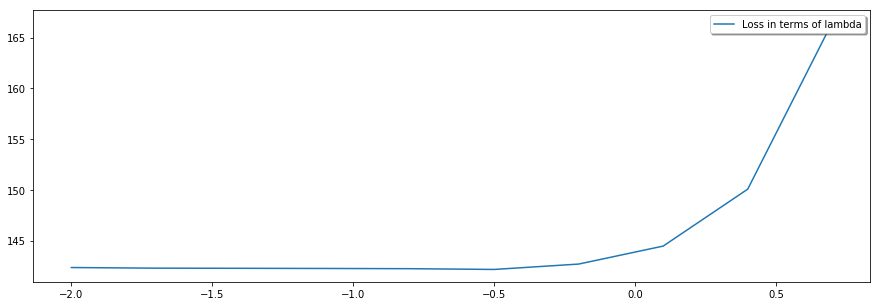

In [8]:
if __name__=="__main__":
    lambda_list=([10**i for i in np.arange(-2.0,1.0,0.3)])
    loss=np.zeros(len(lambda_list))
    for i,ll in enumerate(lambda_list):
        (LR_w,loss_temp,loss_hist)=func_3_1_2_Lasso(x_train_f,y_train,lambda_reg=ll,randomize=True)
        loss[i]=np.sum((np.dot(LR_w,x_val_f.T)-y_val)**2)
        #loss_val[i]=np.sum((np.dot(w,x_val_f.T)-y_val)**2)
    print(loss)
    fig,ax1=plt.subplots(figsize=(15,5))
    lines=locals()
    lines['lambda_LR'],=ax1.plot(np.log10(lambda_list), loss, label='Loss in terms of lambda')
    legend = ax1.legend(loc='upper right', shadow=True)
    plt.show()

15.3140547266


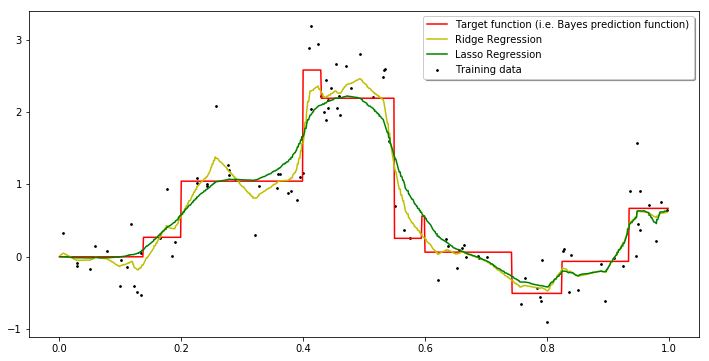

C:\Applications\Programming\Anaconda\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


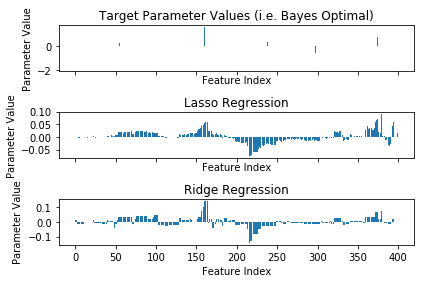

In [253]:
def func3_1_3():
    from sklearn.linear_model import LinearRegression
    #Data Visualization
    lines=locals() #Initialize lines
    fig1, ax1 = plt.subplots(figsize=(12,6))
    x = np.arange(0,1,.001)
    x_val_f=featurize(np.sort(x_val))
    #RR part
    ridge_regression_estimator = RidgeRegression(l2reg=0.1)
    ridge_regression_estimator.fit(x_train_f, y_train)
    our_coefs = ridge_regression_estimator.w_
    y_pred=ridge_regression_estimator.predict(x_val_f)
    #LR part
    (LR_w,loss_temp,loss_hist)=func_3_1_2_Lasso(x_train_f,y_train,lambda_reg=0.01,randomize=True)
    y_pred_LR=np.dot(x_val_f,LR_w)
    
    lines['TD']=plt.scatter(x_train, y_train, s=3, color='k', label='Training data')
    lines['TF'],=ax1.plot(x, target_fn(x), 'r', label='Target function (i.e. Bayes prediction function)')
    lines['PD'],=ax1.plot(np.sort(x_val),y_pred,'y',label='Ridge Regression')
    lines['LR'],=ax1.plot(np.sort(x_val),y_pred_LR,'g',label='Lasso Regression')
    legend = ax1.legend(loc='upper right', shadow=True)
    #ax1.set_ylim([-1.2,3.5])
    plt.show(block=False)
    
    #Func Visualization
    #fig2, ax2 = plt.subplots(figsize=(12,6))
    pred_fns=[]
    x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
    X=featurize(x)
    name = "Target Parameter Values (i.e. Bayes Optimal)"
    pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })
    name="Lasso Regression"
    pred_fns.append({"name":name,
                     "coefs":LR_w,
                     "preds": np.dot(X,LR_w) })
    name="Ridge Regression"
    pred_fns.append({"name":name,
                     "coefs":ridge_regression_estimator.w_,
                     "preds": ridge_regression_estimator.predict(X) })

    f = compare_parameter_vectors(pred_fns)
    f.show()

if __name__=='__main__':
    func3_1_3()

<b>Conclusion:</b><br>
The best lambda for Lasso Regression is around $\lambda=0.01$. Parameters of Lasso Regression is less sparce than Ridge Regression, and the curve is smoother thant Ridge Regression. Based on the line chart and bar charts, the best model should be Lasso Regression with randomization, $\lambda=0.01$, while the initial w value does not influence the final result a lot.

#### 3.1.4 Homotopy method

In [6]:
lambda_max=2*np.linalg.norm(np.dot(x_train_f.T,(y_train-np.mean(y_train))),ord=np.inf)
lambda_max

55.939118926558344

136.719312271
129.537904293
109.668437207
76.2453182448
46.0708929825
26.9249842869
18.679045256
16.0468733225
15.3474680079
15.2205142235
15.2026920694
15.2010726506
15.2023715047
15.2031717663
15.2017400292
15.2008618148
15.2024117822
15.2019040514
15.1996877422
15.201098646
15.2016197018
15.2017460411
15.2026322052
15.2008923002
15.2001164455
15.2010469624
15.2017094428
15.2032055232
15.2032918634
15.2011875122


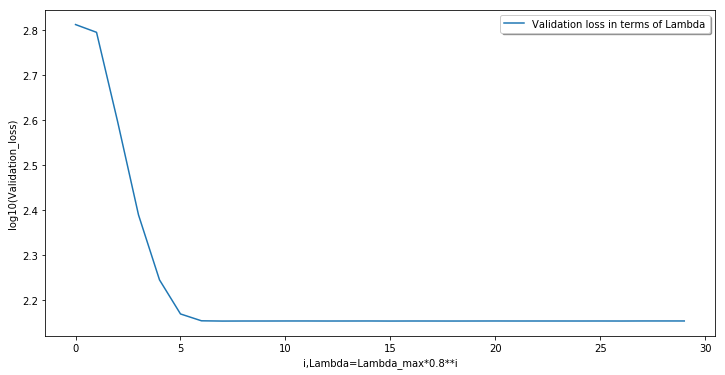

In [262]:
def func3_1_4_homotopy_method():
    lambda_max=2*np.linalg.norm(np.dot(x_train_f.T,y_train),ord=np.inf)
    w=np.zeros(x_train_f.shape[1])
    lam_reg=lambda_max
    loss_val=np.zeros(30)
    x_val_f=featurize(x_val)
    for i in range(30):
        lam_reg=lam_reg*(0.8**i)
        (w,loss_temp,loss_hist)=func_3_1_2_Lasso(x_train_f,y_train,
                                                 w_init=w,lambda_reg=lam_reg,init="homotopy",
                                                 epsilon=1e-8,n=1000,randomize=True)
        loss_val[i]=np.sum((np.dot(w,x_val_f.T)-y_val)**2)
    fig,ax1=plt.subplots(figsize=(12,6))
    lines=locals()
    lines['homotopy_lambda'],=ax1.plot(range(30),np.log10(loss_val),label='Validation loss in terms of Lambda')
    ax1.set_ylabel('log10(Validation_loss)')
    ax1.set_xlabel('i,Lambda=Lambda_max*0.8**i')
    legend=ax1.legend(loc='upper right',shadow=True)
    #plt.xticks([range(2)],[lambda_max*0.8**i for i in np.arange(0,2,1)])
    plt.show(block=False)
if __name__=="__main__":
    func3_1_4_homotopy_method()

### 3.2 Deriving the Coordinate Minimizer for Lasso
#### 3.2.1
  Since $x_{ij}=0$ for any i, $f(w_{j})$ turns into:
  $$f(w_{j})=\sum[-y_{i}]^{2}+\lambda|w_{j}|+\lambda\sum_{k\ne{j}}|w_{k}|$$
  It's simple that the minimizer is $w_{j}=0$ since $f$ is in linear relation ship with $w_{j}$

#### 3.2.2 
$$f'(w_{j})=w_{j}a_{j}-c_{j}+\lambda{sign(w_{j})}$$

#### 3.2.3
  For a minimizer $w_{j}>0$, $f'(w_{j})$ should satisfy
  $$f'(w_{j})=0 | w_{j}>0\Rightarrow{w_{j}a_{j}-c_{j}+\lambda=0}\Rightarrow{w_{j}=\frac{1}{a}(c_{j}-\lambda)}$$
  In which $c_{j}$ must satisfy:
  $$c_{j}>\lambda$$
  For a minimizer $w_{j}<0$, $f'(w_{j})$ should satisfy
  $$f'(w_{j})=0 | w_{j}<0\Rightarrow{w_{j}a_{j}-c_{j}-\lambda=0}\Rightarrow{w_{j}=\frac{1}{a}(c_{j}+\lambda)}$$
  In which $c_{j}$ must satisfy:
  $$c_{j}<-\lambda$$

#### 3.2.4 
  For $w_{j}>0$, we can get $lim_{w_{j}\rightarrow{0}}f'(w_{j})=0*a_{j}-(c_{j}-\lambda)_{c_{j}\rightarrow{\lambda}}=0$<br>
    For $w_{j}<0$, we can get $lim_{w_{j}\rightarrow{0}}f'(w_{j})=0*a_{j}-(c_{j}+\lambda)_{c_{j}\rightarrow{-\lambda}}=0$
  So although $f$ is not continuous at $w_{j}=0$, $f'(w_{j})$ is continuous. So $w_{j}=0$ is the minimizer with $c_{j}\in[-\lambda,\lambda]$

#### 3.2.5
Since we got the conclusion in 3.2.3, and 3.2.4 which is:<br>
When $c_{j}>\lambda$, $w_{j}>0$, minimizer $w_{j}=\frac{1}{a}(c_{j}-\lambda)$, when $c_{j}\in[-\lambda,\lambda]$ minimizer $w_{j}=0$, when $c_{j}<-\lambda$, $w_{j}0$, minimizer $w_{j}=\frac{1}{a}(c_{j}+\lambda)$<br>
So we can get the expression in 3.2.5, which is equivalent to those in 3.2.3 and 3.2.4.

### 4 Lasso Properties

#### 4.1 Deriving $\lambda_{max}$
#### 4.1.1
Solution:<br>
$$J'(0;v)=\lim_{h\rightarrow{0}}\frac{J(0+hv)-J(0)}{h}$$
$$=\lim_{h\rightarrow{0}}\frac{||X(0+hv)-y||_{2}^{2}+\lambda||0+hv||_{1}-||X0-y||_{2}^{2}-\lambda||0||_{1}}{h}$$
$$=\lim_{h\rightarrow{0}}\frac{||Xhv-y||_{2}^{2}+\lambda{h}||v||_{1}-||y||_{2}^{2}}{h}$$
For the first item in numerator, we rewrite it as:
$$\sum_{i=1}^{n}{y_{i}^{2}(1-\frac{x_{i}hv}{y_{i}})^{2}}$$
Since $\frac{x_{i}hv}{y_{i}}<<1$ , we can get the approximation:
$$\sum_{i=1}^{n}{y_{i}^{2}(1-\frac{x_{i}hv}{y_{i}})^{2}}=\sum_{i=1}^{n}{y_{i}^{2}(1-\frac{2x_{i}hv}{y_{i}})}$$
So we rewrite $J'(0;v)$ as:
$$J'(0;v)=\lim_{h\rightarrow{0}}\frac{\sum_{i=1}^{n}{(y_{i}^{2}-2x_{i}hvy_{i})}+\lambda{h}||v||_{1}-||y||_{2}^{2}}{h}$$
$$=\lim_{h\rightarrow{0}}\frac{-2h(Xv)^{T}y+\lambda{h}||v||_{1}}{h}$$
$$=\lambda||v||_{1}-2(Xv)^{T}y$$

#### 4.1.2 Calculate C
Solution:<br>
We need $J'(0;v)\ge0$ for any $\lambda\ge{C}$ holds. That is:
$$\lambda||v||_{1}-2(Xv)^{T}y\ge{0}\Rightarrow\lambda\ge\frac{2(Xv)^{T}y}{||v||_{1}}$$
So for any given $v$, we can set C as $\frac{2(Xv)^{T}y}{||v||_{1}}$ such that any $\lambda\ge{C}$ satisfies $J'(0;v)\ge0$.<br>

#### 4.1.3 Max $\lambda$
Since $2(Xv)^{T}y=2v^{T}X^{T}y\le2||v||_{1}||X^{T}y||_{\infty}$, we can get a $C\le{C_{max}}=2||X^{T}y||_{\infty}$, for all $v\ne{0}$ and $\lambda\ge{C_{max}}$, $J'(0;v)\ge0$. Considering the arbitrariness of $v$, this $C_{max}$ is a tight lower bound of all possible $C$s. <br>
It's obvious that if $w=0$ is a minimizer of $J(w)$, $\lambda\ge2||X^{T}y||_{\infty}$, based on the derivation. Now let's prove the necessity.<br>
<br>
Since we know $\lambda\ge2||X^{T}y||_{\infty}$, for any $v$, we have:<br>
$$J'(0;v)=\lambda||v||_{1}-2(Xv)^{T}y\ge2||X^{T}y||_{\infty}||v||_{1}-2(Xv)^{T}y$$
For the second item, we have:<br>
$$2(Xv)^{T}y=2\sum_{j=1}^{D}v_{j}X[j]^{T}y\le2\sum_{j=1}^{D}|v_{j}|max_{j\in[1,D]}(X[j]^{T}y)=2||v||_{1}||X^{T}y||_{\infty}$$
So for any $v$, $J'(0;v)\ge{0}$.<br>
So $w=0$ is a minimizer of $J(w)$.

#### 4.1.4 Optimal $w$ and $b$
Consider $Y=y-\bar{y}$. Since $w$ and $b$ are independent, we could minimize the $J$ func sequencially by optimizing the 
$$||Xw+b1-Y-\bar{y}||_{2}^{2}+\lambda{||w||_{1}}$$
function. Based on the former proof, it's minimizer is $w^{*}=0$ if and only if $\lambda\ge{2||X^{T}Y||_{\infty}}$.<br>
Then let's find the optimal b. Since $\bar{Y}=0$, we can only get the minimal variation when bias is 0, i.e. $(b1-\bar{y})=0$. So we get the minimizer $b=\bar{y}$.

#### 4.2 Feature Correlation
#### 4.2.1 Finding multiple $\hat{\theta}$ for Lassso
Solution:<br>
We have:<br> 
$$X=\left( \begin{array}{ccc} x_{1} & x_{2} & X_{r} \end{array}\right), \theta=\left( \begin{array}{ccc}
    \theta_{1} \\
    \theta_{2}\\
    \theta_{r}
\end{array}\right)$$
The optimization target is:<br>
$$J(\theta)=||x_{1}(\theta_{1}+\theta_{2})+X_{r}\theta_{r}-y||_{2}^{2}+\lambda(|\theta_{1}|+|\theta_{2}|)+\lambda||\theta_{r}||_{1}$$
$$\ge||x_{1}(\theta_{1}+\theta_{2})+X_{r}\theta_{r}-y||_{2}^{2}+\lambda(|\theta_{1}+\theta_{2}|)+\lambda||\theta_{r}||_{1}$$
So we can consider this as a optimization problem for $Z\in{R}^{m\times{(d-1)}}$, whose coefficients is $\psi$, and whose minimal is a definite lower bound of the original problem.<br>
If there's a optimal solution for $Z$ which is:<br>
$$\psi=(\psi_{12},\psi_{r}^{T})^{T}$$
We can get a corresponding optimal solution for $X$, which satisfies:<br>
$$\theta_{1}+\theta_{2}=\psi_{12},|\theta_{1}|+|\theta_{2}|=|\psi_{12}|$$
So if we have a minimizer of $J(\theta)$ $\hat{\theta}=(a,b,r^{T})^{T}$, we could find infinitely many $c$ and $d$s for which $\theta=(c,d,r^{T})^{T}$ is also minimizer, as long as c and d satisfy:<br>
$$c+d=a+b,|c|+|d|=|a|+|b|$$
Which means a and b should be both $\ge0$ or $\le0$, while c and d should also be both $\ge0$ or $\le0$, corresponding with a and b.

#### 4.2.2 Finding $\hat{\theta}$ for Ridge
Solution:<br>
Objective function of Ridge Regression is:<br>
$$J(\theta)=\frac{1}{n}||X\theta-y||_{2}^{2}+\lambda||\omega||_{2}^{2}$$
$$=\frac{1}{n}||x_{1}(\theta_{1}+\theta_{2})+X_{r}\theta_{r}-y||_{2}^{2}+\lambda(|\theta_{1}|^{2}+|\theta_{2}|^{2})+\lambda||\theta_{r}||_{2}^{2}$$
If a optimal solution is $\hat{\theta}=(a,b,r^{T})^{T}$, a and b should satisfy:
$$a=b$$
Only in this case, a and b both $\ge0$ or $\le0$, and since their sum is fixed, $|a|^{2}+|b|^{2}$ will be minimmized since $a^{2}+b^{2}\ge2[(a+b)/2]^{2}$ when $a=b$, equality holds.